## Sử dụng Python để kiểm định thống kê bằng z-test

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats, interpolate
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 18})

Z-test: So sánh mean của mẫu với mean của tổng thể. Điều kiện sử dụng Z-test:

- Phương sai $\sigma$ đã biết và cỡ mẫu N tùy ý.
- Phương sai chưa biết và $N \geq 30$.
- Nếu $N < 30$ thì cần kiểm tra dữ liệu là phân phối chuẩn.

### Kiểm định 2 phía:

$H_0: \mu = \mu_0$

$H_1: \mu \neq \mu_0$

- Với mức ý nghĩa $\alpha$ (significant level), ta cần cho $P(|X| > t_*) = \alpha$. Giá trị $t_*$ được gọi là `giá trị tới hạn` (critical value)

- Cách tính $t_*$: Ta có $P(|X| \leq t_*) = 1 - \alpha$. Do tính đối xứng, ta có:
 $P(0 \leq X \leq t_*) = P(-t_* \leq X \leq 0) = \frac{1-\alpha}{2}$

điều này tương đương với $\phi_(t_*) = \frac{1-\alpha}{2}$
 
 __`Ví dụ`__ : Với $\alpha = 0.05$ thì $\frac{1-\alpha}{2} = 0.475$. Ta cần giải phương trình $\phi_(t_*) = 0.475$. Từ bảng $A_2$ ta có $t_* = \phi^{-1} (0.475) = 1.96$

 __`Ví dụ`__ : Với $\alpha = 0.01$ thì $\frac{1-\alpha}{2} = 0.495$. Ta cần giải phương trình $\phi_(t_*) = 0.495$. Từ bảng $A_2$ ta có $t_* = \phi^{-1} (0.495) = 2.57$

 - Miền bác bỏ: $B_\alpha = (-\infty, -t_*) \bigcup (t_*, +\infty)$
 
 - Gọi $K_{tn}$ (statistical score) là giá trị thống kê thực nghiệm được tính ra từ mẫu. Ta có giá trị $p (p$ value) được tính bởi: 
 $p = P(|X| > K_{tn})$

__Kết luận__:

 Nếu $K_{tn} \in B_\alpha$ thì bác bỏ giả thiết $H_0$. Điều này tương đương với $p < \alpha$

### Kiểm định 1 phía:

$H_0: \mu = \mu_0.$

$H_1: \mu > \mu_0. (H_1: \mu < \mu_0).$

### Tính giá trị tới hạn bằng Python:

In [6]:
# Tính giá trị tới hạn bằng scipy và hàm ppf (hàm ngược của hàm cdf) #
from scipy.stats import norm
def critical_value(alpha, tail=0):
    '''Tính giá trị tới hạn: tail=0:: 2phia; tail=-1:left; tail=1:right'''
    if tail == -1: return norm.ppf(alpha)
    elif tail == 1: return norm.ppf(1-alpha)
    else: return (norm.ppf(alpha/2), norm.ppf(alpha))

alpha = 0.05
# tu bang A.2 chon t_* = 1.96
# dung ham cdf de tinh gia tri p chinh xac neu t_*=1.96
print(f"Giá trị tới hạn 2 phía: {critical_value(alpha)}")
print(f"Giá trị tới hạn 1 phía (trái): {critical_value(alpha, tail=-1)}")
print(f"Giá trị tới hạn 1 phía (phải): {critical_value(alpha, tail=1)}")
# Khi thi ta chấp nhận t_* = 1.96
# Trong khi thực hành thì ta không chấp nhận t_*=1.96 mà giá trị thực là t_* = 1.959963984540054

Giá trị tới hạn 2 phía: (-1.9599639845400545, -1.6448536269514729)
Giá trị tới hạn 1 phía (trái): -1.6448536269514729
Giá trị tới hạn 1 phía (phải): 1.6448536269514722


__Thực hành__: Viết hàm tính giá trị tới hạn 1 phía: $\mu > \mu_0$ và $\mu < \mu_0.$

In [7]:
gia_nha_dat_us = pd.read_csv("gia_nha_dat_us.csv")
gia_nha_dat_us.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df = gia_nha_dat_us[['MSSubClass', 'MSZoning', 'LotArea', 'SalePrice']]
df.head()

,MSSubClass,MSZoning,LotArea,SalePrice
0,60,RL,8450,208500
1,20,RL,9600,181500
2,60,RL,11250,223500
3,70,RL,9550,140000
4,60,RL,14260,250000


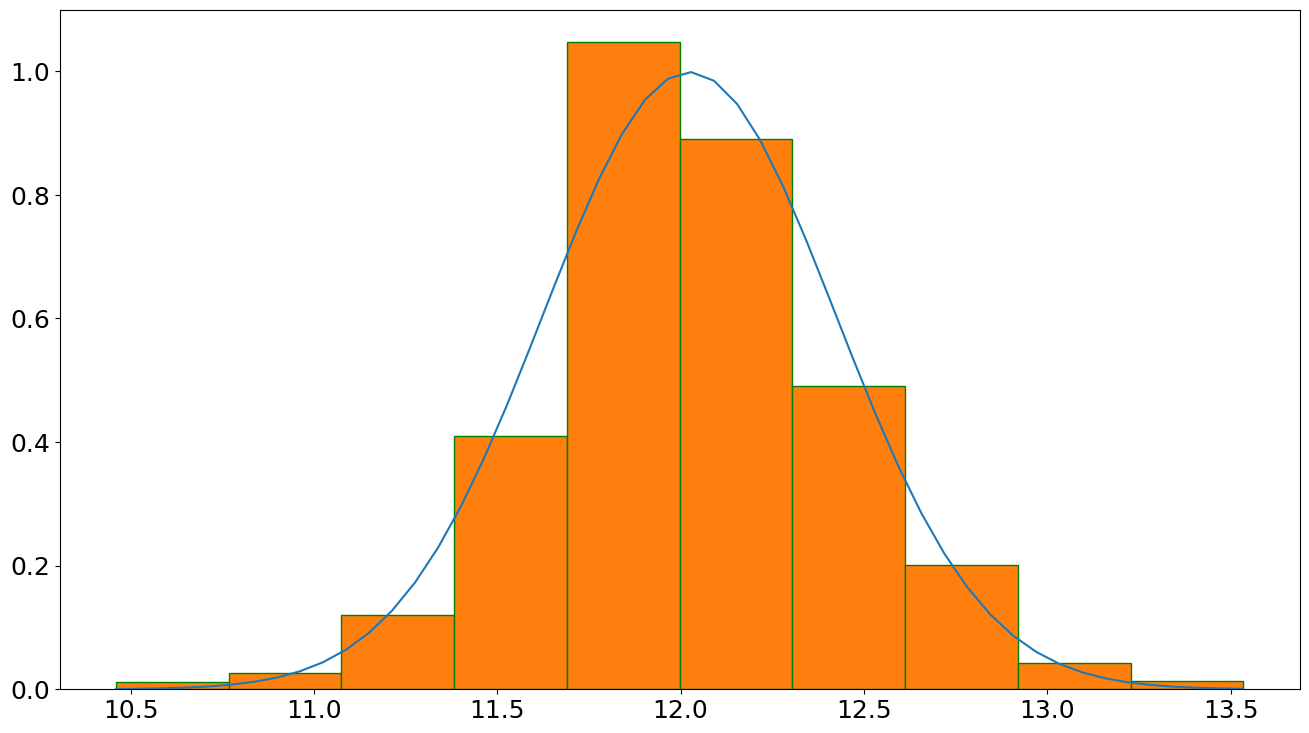

In [9]:
# Engineering feature: log transform #
data = df['SalePrice']
# Sử dụng ln(1+r) ~ r để tránh rate of change #
data = np.log1p(data)

# Kiem tra data co chuan hay khong?
mean = np.mean(data)
# ddof=1 :: hiệu chỉnh
std = np.std(data, ddof=1)
domain = np.linspace(np.min(data), np.max(data))
plt.plot(domain, stats.norm.pdf(domain, mean, std))
#density=True :: chuẩn hóa dữ liệu về normal
plt.hist(data, edgecolor='green', density=True)
plt.show()

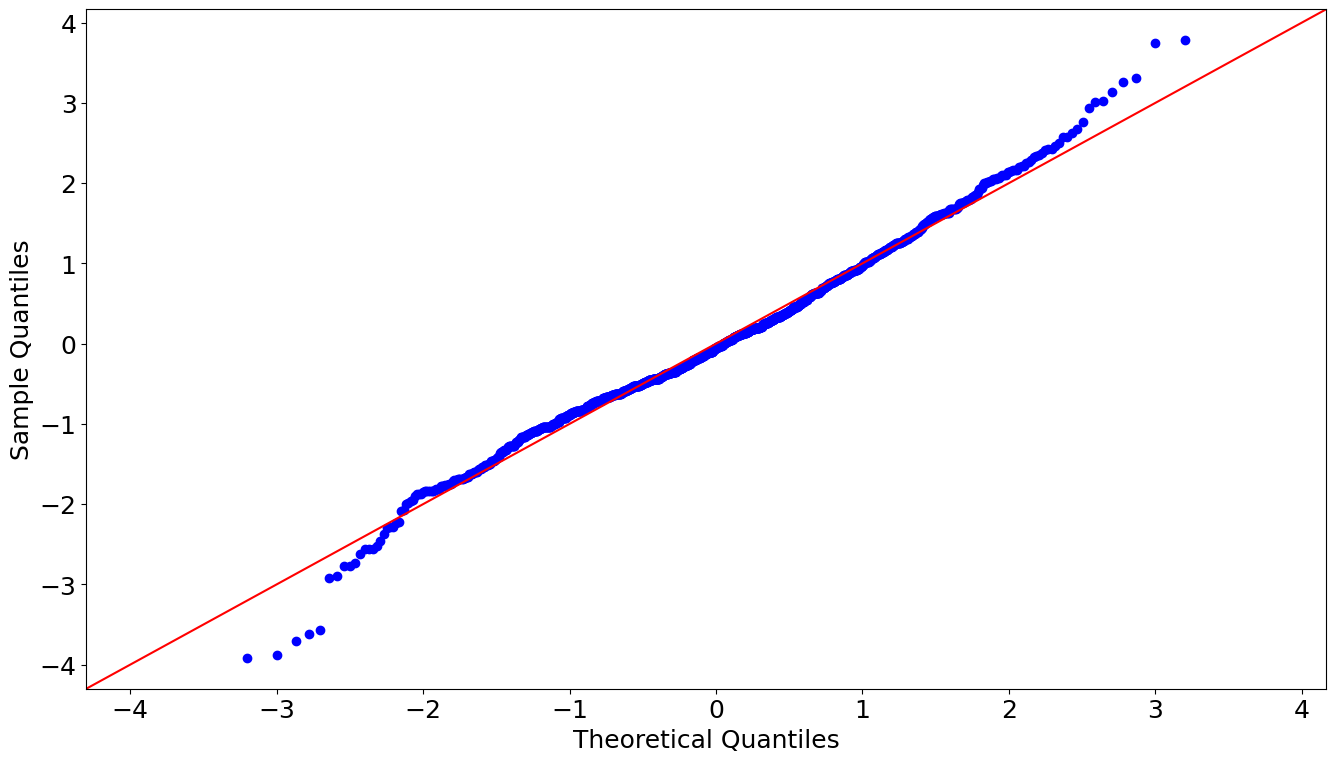

In [10]:
import statsmodels.api as sm
# Đưa dữ liệu về dạng chuẩn tắc #
def standadize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean)/std

sm.qqplot(standadize(data), line ='45')
plt.show()

__Bài toán__: Có người cho rằng giá nhà trung bình ở Mỹ là $150k, khẳng định trên có đúng không về mặt thống kê với mức ý nghĩa là 5%?

(Bài toán so sánh giá trị trung bình mẫu với trung bình kỳ vọng lý thuyết $\mu_0$)

In [11]:
my_mean = 150000
my_log_mean = np.log1p(my_mean)
print(my_log_mean)

11.918397239722838


Giả thuyết thống kê:

$H_0: \mu = 11.918397239722838$

$H_1: \mu \neq 11.918397239722838$

In [12]:
def results(p, vals=['mean1', 'mean2'], alpha=0.05):
    cols=['score', 'p_value', 'KetLuan']
    if p['p_value'] < alpha:
        p['KetLuan'] = f"Chấp nhận H1 với mức ý nghĩa {alpha}"
    if p['p_value'] >= alpha:
        p['KetLuan'] = f"Chấp nhận H0 với mức ý nghĩa {alpha}"
    df = pd.DataFrame(p, index=[''])
    if vals: cols = vals + cols
    return df[cols]

In [13]:
# Lay ngau nhien 100 diem du lieu #
sample = data.sample(n=100)

In [14]:
#Kiem dinh mean cua sample so voi ky vong mu_0=11.918397239722838
# kiem dinh 2 phia: H0: mu = mu_0, H1: mu != mu_0
from scipy.stats import ttest_1samp
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean)
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.063403,11.918397,3.405336,0.000956,Chấp nhận H1 với mức ý nghĩa 0.05


### Kiểm định 1 phía 

In [26]:
# alternative{‘two-sided’, ‘less’, ‘greater’}
# kiem dinh ben trai: H0 mu = mu_0, H1: mu < mu_0
import scipy
from scipy import stats
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean)
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.063403,11.918397,3.405336,0.000956,Chấp nhận H1 với mức ý nghĩa 0.05


In [27]:
# alternative{‘two-sided’, ‘less’, ‘greater’}
# kiem dinh ben phai: H0 mu = mu_0, H1: mu > mu_0
p = {}
p['mean1'] = np.mean(sample)
p['mean2'] = my_log_mean
p['score'], p['p_value'] = ttest_1samp(sample, my_log_mean)
results(p)

,mean1,mean2,score,p_value,KetLuan
,12.063403,11.918397,3.405336,0.000956,Chấp nhận H1 với mức ý nghĩa 0.05


__ Bài tập về nhà:__

a) Hãy chọn giá trị n lớn hơn 100 khác nhau và chạy các thống kê ở trên để đưa ra kết luận.

b) Hãy thay đổi my_mean khác nhau để tìm ra được giá trị kì vọng gần với giá trị trung bình mẫu (với mức ý nghĩa là 0.05)